#    I. Importations et paramétrage

In [16]:
#!pip install pyarrow
#!pip install findspark

In [17]:
# Constants
from keys import ACCESS_KEY_ID, SECRET_ACCESS_KEY
REGION = 'eu-west-3'
BUCKET_NAME = 'ocr-taille-variable'
DATASET = 'Training'

In [18]:
# Imports
import findspark
findspark.init()

import boto3
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyspark
import random
import tensorflow as tf

from botocore.config import Config
from boto3 import session

from io import StringIO

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from PIL import Image

from pyspark import SparkContext
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import array, col, lit, monotonically_increasing_id, pandas_udf, PandasUDFType, row_number, split
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, IntegerType, StringType

In [19]:
# Others
os.environ['SPARK_HOME'] = '/opt/spark'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

# II. EDA

##    A. Chargement des données via Spark

### 1) Préparation

In [20]:
# Spark session
spark = (SparkSession
             .builder.master('local[*]')
             .appName('p8_ocr')
             .config('spark.hadoop.fs.s3a.access.key', ACCESS_KEY_ID)
             .config('spark.hadoop.fs.s3a.secret.key', SECRET_ACCESS_KEY)
             .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
             .config('com.amazonaws.services.s3.enableV4', 'true')
             .config('spark.hadoop.fs.s3a.endpoint', 's3.' + REGION +'.amazonaws.com')
             .getOrCreate())

In [21]:
# Spark context and log level
spark_context = spark.sparkContext
spark_context.setLogLevel('WARN')

In [22]:
# S3 / EC2 authorizations
s3 = boto3.resource('s3',
                                 REGION,
                                 aws_access_key_id=ACCESS_KEY_ID,
                                 aws_secret_access_key=SECRET_ACCESS_KEY)
bucket = s3.Bucket(BUCKET_NAME)
images_list = list(s3_object.key for s3_object in bucket.objects.filter(Prefix=DATASET))

In [23]:
def path_dataframe(img_list):
    zipped_fruits = zip(img_list)
    path_sdf = spark.createDataFrame(zipped_fruits, ['image_path'])
    return path_sdf


@udf('string') # UDF = User Defined Function
def fruit_name(path):
    fruit = path.split('/')[-2]
    return fruit


@udf('string')
def jpeg_name(path):
    img_name = path.split('/')[-1]
    img_name = img_name[:-4]
    return img_name


def readable_columns(path_sdf):
    sdf = path_sdf.withColumn('fruit', fruit_name('image_path'))
    sdf = sdf.withColumn('JPEG', jpeg_name('image_path'))
    return sdf


path_sdf = path_dataframe(images_list)
image_sdf = readable_columns(path_sdf)

### 2) Prédictions

In [24]:
# Model instanciation
resnet_model = ResNet50(include_top=False, # whether to include the fully-connected layer at the top of the network.
                                           weights=None, # random initialization
                                           pooling='max', # global max pooling will be applied
                                           input_shape=(224, 224, 3))

In [25]:
def images_sample(image_list, img_nb=2400):
    new_images_list = random.choices(images_list, k=img_nb)
    return new_images_list


def clean_image(path):
    obj = bucket.Object(path)
    img_body = obj.get()['Body']
    image = Image.open(img_body).resize((224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image


def model_image_prediction(model, image):
    clean_img = clean_image(image)
    model_feature = model.predict(clean_img).ravel().tolist()
    return model_feature


def predictions_dataframe(model, data):
    resnet_features = [model_image_prediction(model, image) for image in data]
    predictions_sdf = spark.createDataFrame([(f,) for f in resnet_features], ['features'])
    return predictions_sdf


random_images_list = images_sample(images_list)
predictions_sdf = predictions_dataframe(resnet_model, random_images_list)

### 3) Fusion et post-processing

In [26]:
def merge_dataframe(img_sdf, pred_sdf):
    img_sdf = img_sdf.withColumn('index',
                                 row_number().over(Window.orderBy(monotonically_increasing_id())))
    pred_sdf = pred_sdf.withColumn('index',
                               row_number().over(Window.orderBy(monotonically_increasing_id())))
    joined_sdf = img_sdf.join(pred_sdf,
                                             img_sdf.index == pred_sdf.index
                                            ).drop('index')
    return joined_sdf


def postprocess_dataframe(sdf):
    #  MLlib supports two types of local vectors: dense and sparse.
    #  A dense vector is backed by a double array representing its entry values.
    to_vector = udf(lambda x: Vectors.dense(x), VectorUDT()) # Assurer la compatibilté des données avec MLib
    sdf = sdf.select('fruit', 'JPEG', to_vector('features').alias('features_vector'))
    return sdf


def standardize_dataframe(sdf):
    standardizer = StandardScaler(withMean=True,
                                                      withStd=True,
                                                      inputCol='features_vector',
                                                      outputCol='features_std')
    std = standardizer.fit(sdf)
    sdf = std.transform(sdf)
    sdf = sdf.select('fruit', 'JPEG', 'features_std')
    return sdf


image_sdf = merge_dataframe(image_sdf, predictions_sdf)
image_sdf = postprocess_dataframe(image_sdf)
image_sdf = standardize_dataframe(image_sdf)

## B. Réduction de dimension

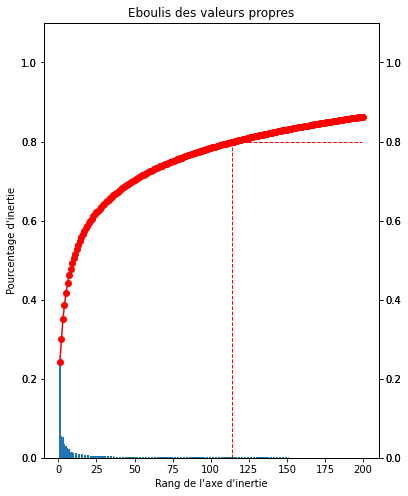

In [27]:
def pca_scree_plot(sdf, n_comp):
    def pca_model_data(n_comp):
        pca_model = pyspark.ml.feature.PCA(k=n_comp,
                                                         inputCol='features_std',
                                                         outputCol='features_pca')
        pca_model = pca_model.fit(sdf)
        scree = pca_model.explainedVariance
        return scree
    
    def eighty_pct_3_points(data):
        data_cumsum = data.cumsum()
        for i, element in enumerate(data_cumsum):
            if element > 0.8:
                x_sup = i
                y_sup = element
                x_inf = i-1
                y_inf = data_cumsum[i-1]
                break
        x_80 = x_inf + (0.8 - y_inf) / (y_sup - y_inf)
        abs_80 = [x_80, 0]
        pt_80 = [x_80, 0.8]
        ord_80 = [n_comp - 1, 0.8]
        return abs_80, pt_80, ord_80
    
    fig = plt.figure(figsize=(6, 8))
    # Bins
    ax1 = fig.add_subplot(111)
    data = pca_model_data(n_comp)
    plt.title("Eboulis des valeurs propres")
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylim((0, 1.1))
    plt.ylabel("Pourcentage d'inertie")
    ax1.bar(np.arange(len(data))+1, data)
    # Cumsum
    ax2 = ax1.twinx()
    plt.ylim((0, 1.1))
    ax2.plot(np.arange(len(data))+1, data.cumsum(), c="red", marker='o')
    # 80% lines
    abs_80, pt_80, ord_80 = eighty_pct_3_points(data)
    # Vertical line
    ax3 = ax2.twinx()
    plt.ylim((0, 1.1))
    ax3.plot([abs_80[0], pt_80[0]], [abs_80[1], pt_80[1]], '--', color='red', linewidth=1)
    # Horizontal line
    ax4 = ax2.twinx()
    plt.ylim((0, 1.1))
    ax4.plot([pt_80[0], ord_80[0]], [pt_80[1], ord_80[1]], '--', color='red', linewidth=1)
    
    
pca_scree_plot(image_sdf, 200)

In [28]:
def pca_dataframe(sdf, n_comp=150):
    pca_model = pyspark.ml.feature.PCA(k=n_comp,
                                                     inputCol='features_std',
                                                     outputCol='features_pca')
    pca_model = pca_model.fit(sdf)
    pca_sdf = pca_model.transform(sdf)
    pca_sdf = pca_sdf.select('fruit', 'JPEG', 'features_pca')
    return pca_sdf


pca_sdf = pca_dataframe(image_sdf)

## C. Enregistrement csv

In [29]:
def save_csv(sdf, csv_name):
    csv_buffer = StringIO()
    pca_df = image_sdf.toPandas()
    pca_df.to_csv(csv_buffer)
    s3.Object(BUCKET_NAME, csv_name).put(Body=csv_buffer.getvalue())


save_csv(image_sdf, 'image_dataframe.csv')

In [30]:
spark.stop()